In [4]:
import os
import os.path as osp

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import shutil
import time

from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'gpu'
import copy

import torch.nn as nn
from sklearn.metrics import accuracy_score, confusion_matrix


In [7]:
IMAGE_TEST_BASE_PATH = '../images-test/'
IMAGE_TRAIN_BASE_PATH = '../images-train/'
IMAGE_VAL_BASE_PATH = '../images-val'


In [3]:
os.listdir(IMAGE_TRAIN_BASE_PATH)

['Cookbooks, Food & Wine',
 'Science Fiction & Fantasy',
 'Computers & Technology',
 'Science & Math',
 'Travel',
 'Test Preparation',
 'Sports & Outdoors',
 "Children's Books",
 'Comics & Graphic Novels',
 'Romance']

In [6]:

if not osp.exists(IMAGE_VAL_BASE_PATH):
    os.mkdir(IMAGE_VAL_BASE_PATH)

for cat in os.listdir(IMAGE_TRAIN_BASE_PATH):
    image_val_cat_path = osp.join(IMAGE_VAL_BASE_PATH, cat)
    if not osp.exists(image_val_cat_path):
        os.mkdir(image_val_cat_path)
    image_cat_path = osp.join(IMAGE_TRAIN_BASE_PATH, cat)
    imgs = os.listdir(image_cat_path)
    num_img = len(imgs)
    take = int((7800/70000) * num_img)
    for i in range(take):
        img_name = imgs[i]
        img_path = osp.join(image_cat_path, img_name)
        os.rename(img_path, osp.join(image_val_cat_path, img_name))

In [5]:
# import os

# os.rmdir('./images-val/Category')

In [ ]:
# os.listdir('./images-train')


In [8]:


# train_dataset = torchvision.datasets.ImageFolder(
#     'images-train',
#     transform=torchvision.transforms.Compose([
#         # Resize step is required as we will use a ResNet model, which accepts at leats 224x224 images
#         torchvision.transforms.Resize((224,224)),
#         torchvision.transforms.ToTensor(),
#     ]),
#     # is_valid_file=lambda x: True if any(fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.ppm', '.pgm', '.tif', '.tiff', '.webp')) for fname in os.listdir(x)) else False

# )

# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=False, num_workers=2, pin_memory=True)

# means = []
# stdevs = []
# for X, _ in train_dataloader:
#     # Dimensions 0,2,3 are respectively the batch, height and width dimensions
#     means.append(X.mean(dim=(0,2,3)))
#     stdevs.append(X.std(dim=(0,2,3)))

# mean = torch.stack(means, dim=0).mean(dim=0)
# stdev = torch.stack(stdevs, dim=0).mean(dim=0)

In [9]:
# train_transforms = torchvision.transforms.Compose([
#         torchvision.transforms.Resize((224,224)),
#         torchvision.transforms.AutoAugment(policy=torchvision.transforms.AutoAugmentPolicy.CIFAR10),
#         torchvision.transforms.ToTensor(),
#         torchvision.transforms.Normalize(mean, stdev)
#     ])

# train_dataset, test_dataset = [torchvision.datasets.ImageFolder(folder, transform=train_transforms) for folder in ['images_train', 'images_test']]

In [5]:
mean, stdev = torch.Tensor([0.5483, 0.5152, 0.4714]), torch.Tensor([0.3267, 0.3070, 0.3118])

In [8]:
train_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.AutoAugment(policy=torchvision.transforms.AutoAugmentPolicy.CIFAR10),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean, stdev)
    ])
test_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean, stdev)
    ])
train_dataset, val_dataset = [torchvision.datasets.ImageFolder(folder, transform=train_transforms) for folder in [IMAGE_TRAIN_BASE_PATH, IMAGE_VAL_BASE_PATH]]
test_dataset = torchvision.datasets.ImageFolder(IMAGE_TEST_BASE_PATH, transform=test_transforms)

In [7]:
## eval

train_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.AutoAugment(policy=torchvision.transforms.AutoAugmentPolicy.CIFAR10),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean, stdev)
    ])
test_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean, stdev)
    ])
train_dataset, = [torchvision.datasets.ImageFolder(folder, transform=test_transforms) for folder in [IMAGE_TRAIN_BASE_PATH]]
test_dataset = torchvision.datasets.ImageFolder(IMAGE_TEST_BASE_PATH, transform=test_transforms)

In [9]:
len(train_dataset), len(val_dataset), len(test_dataset)

(62372, 7818, 6577)

In [10]:
num_gpus = torch.cuda.device_count()

train_dataloader = (torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=2*num_gpus, pin_memory=True))
val_dataloader = (torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=2*num_gpus, pin_memory=True))
test_dataloader = (torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2*num_gpus, pin_memory=True))

In [20]:
def get_net():
    vgg = torchvision.models.vgg16(pretrained=True)
    for param in vgg.parameters():
        param.requires_grad = False
    # Unfreeze the last layer
    vgg.classifier[6] = torch.nn.Linear(4096, 10)
    for param in vgg.classifier.parameters():
        param.requires_grad = True

    # vgg.classifier[6].requires_grad = True
    # Substitute the FC output layer
    return vgg

In [17]:
import time
from tqdm import tqdm
import shutil

CKPT_PATH = f'./ckpt/vgg16big_best.pth.tar'


def train(net, train_dataloader, val_dataloader, criterion, optimizer, scheduler=None, scaler=None, epochs=10, patient=5, device='gpu', checkpoint_epochs=50):
    start = time.time()
    print(f'Training for {epochs} epochs on {device}')
    max_val_acc = 0
    current = 0
    best_val_epoch = -1

    # dataloader_progressbar = tqdm(train_dataloader)
    # val_dataloader_progressbar = tqdm(val_dataloader)

    for epoch in range(1,epochs+1):
        print(f"Epoch {epoch}/{epochs}")

        net.train()  # put network in train mode for Dropout and Batch Normalization
        train_loss = torch.tensor(0., device=device)  # loss and accuracy tensors are on the GPU to avoid data transfers
        train_accuracy = torch.tensor(0., device=device)
        val_loss = torch.tensor(0., device=device)
        val_accuracy = torch.tensor(0., device=device)
        for X, y in tqdm(train_dataloader):
            X = X.to(device)
            y = y.to(device)
            with torch.autocast(device_type=device, dtype=torch.float16, enabled=True):
                preds = net(X)
                loss = criterion(preds, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            # optimizer.zero_grad()
            # loss.backward()
            # optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            with torch.no_grad():
                train_loss += loss * train_dataloader.batch_size
                train_accuracy += (torch.argmax(preds, dim=1) == y).sum()
        with torch.no_grad():
            for X, y in tqdm(val_dataloader):
                X = X.to(device)
                y = y.to(device)
                preds = net(X)
                loss = criterion(preds, y)
                val_loss += loss * val_dataloader.batch_size
                val_accuracy += (torch.argmax(preds, dim=1)==y).sum()


        if scheduler is not None:
            scheduler.step()

        print(f'Training loss: {train_loss/len(train_dataloader.dataset):.2f}')
        print(f'Training accuracy: {100*train_accuracy/len(train_dataloader.dataset):.2f}')

        epoch_val_acc = 100*val_accuracy/len(val_dataloader.dataset)
        print(f'Val accuracy: {epoch_val_acc:.2f}')
        print(f'Best val accuracy: {max_val_acc}')

        if epoch_val_acc <= max_val_acc:
            current+=1
            if current==patient:
                print(f"reload checkpoint {best_val_epoch} with val accuracy {max_val_acc}")
                checkpoint = torch.load(CKPT_PATH)
                net.load_state_dict(checkpoint['state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer'])
                scaler.load_state_dict(checkpoint['scaler'])
                current=0
        else:
            current = 0
            max_val_acc = epoch_val_acc
            best_val_epoch = epoch
            print(f"Best epoch {epoch} with val accuracy {epoch_val_acc}")
            print("Save checkpoint to {}".format(CKPT_PATH))
            torch.save({
                'epoch': epoch,
                'state_dict': net.state_dict(),
                'optimizer': optimizer.state_dict(),
                "scaler": scaler.state_dict()
            }, CKPT_PATH)

        # if epoch%checkpoint_epochs==0:
        #     torch.save({
        #         'epoch': epoch,
        #         'state_dict': net.state_dict(),
        #         'optimizer': optimizer.state_dict(),
        #     }, f'/content/drive/MyDrive/ML/ckpt/tho/vgg16_12k/checkpoint_{epoch}.pth.tar')

        print()

    end = time.time()
    print(f'Total training time: {end-start:.1f} seconds')
    return net

In [11]:
# a = torch.load('/content/drive/MyDrive/ML/end_term/checkpoint.pth.tar')
# print(a.keys())

In [13]:
def resume_train():
    device = 'cuda' if torch.cuda.is_available() else 'gpu'
    model = get_net().to(device)
    criterion = torch.nn.CrossEntropyLoss()
    # use_amp = True
    # scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
    lr, weight_decay, epochs = 1e-5, 5e-4, 50
    params_1x = [param for name, param in model.named_parameters() if 'fc' not in str(name)]
    # optimizer = torch.optim.Adam([{'params':params_1x}, {'params': model.fc.parameters(), 'lr': lr*10}], lr=lr, weight_decay=weight_decay)

    optimizer = torch.optim.Adam(model.parameters())
    checkpoint = torch.load(f'/content/drive/MyDrive/ML/ckpt/resnet/checkpoint_best.pth.tar')
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    # scaler.load_state_dict(checkpoint['scaler'])
    epoch = checkpoint["epoch"] + 1
    max_val_acc = checkpoint["val_acc"]
    # epoch = 1
    # max_val_acc = 0
    return model, criterion, optimizer, epoch, max_val_acc

In [14]:
# checkpoint = torch.load(f'/content/drive/MyDrive/ML/ckpt/resnet/checkpoint_best.pth.tar')
# checkpoint.keys()

In [15]:
# model, criterion, optimizer, epoch, max_val_acc = resume_train()

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'gpu'
lr, weight_decay, epochs = 1e-5, 5e-4, 50

model = get_net().to(device)

# Standard CrossEntropy Loss for multi-class classification problems
criterion = torch.nn.CrossEntropyLoss()
use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
optimizer = torch.optim.Adam(model.parameters())

net = train(model, train_dataloader=train_dataloader, val_dataloader=val_dataloader,
            criterion=criterion, optimizer=optimizer, scaler=scaler, scheduler=None, epochs=epochs,
            patient=10, device=device)

In [17]:

# net = train(model, train_dataloader=train_dataloader, val_dataloader=val_dataloader,
#             criterion=criterion, optimizer=optimizer, scheduler=None,
#             epochs=50, patient=10, device=device, checkpoint_epochs=1, start_epoch=epoch,
#             max_val_acc=max_val_acc)

In [18]:
checkpoint = torch.load('ckpt/vgg16big.pth.tar')

In [21]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [19]:
class ModelSoftmax(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = self.model(x)
        y = self.softmax(x)
        return y


In [20]:
net = get_net()
net.load_state_dict(checkpoint['state_dict'])
netsoftmax = ModelSoftmax(net).to(device).eval()

In [31]:
net.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [21]:
idx = 0
img_names = copy.deepcopy(train_dataset.imgs)
preds = []
y_lst = []

for X, y in train_dataloader:
    X=X.to(device)
    img_name_start_idx = idx*64
    preds.extend(netsoftmax(X).detach().cpu().numpy())
    y_lst.extend(y.numpy())

In [22]:
img_names = copy.deepcopy(train_dataset.imgs)

In [23]:
traindf = pd.read_csv("./data/book-full-listing-train.csv")
testdf = pd.read_csv("./data/book-full-listing-test.csv")

In [24]:
img_names[0][0].split('/')[-1]

'0001956604.jpg'

In [25]:
for i in range(len(img_names)):
    img_names[i] = list(img_names[i])
    img_names[i][0] = img_names[i][0].split('/')[-1]

In [26]:
for i in range(len(img_names)):
    img_names[i].append(preds[i])

In [27]:
traindf.columns

Index(['Amazon ID (ASIN)', 'Filename', 'Image URL', 'Title', 'Author',
       'Category ID', 'Category', 'label', 'resnet34mini', 'corpus'],
      dtype='object')

In [30]:
img_names[0][2].shape

(1000,)

In [104]:
img_names_df = pd.DataFrame(img_names, columns=['Filename', 'label', 'resnet34mini'])

In [108]:
traindf = traindf.merge(img_names_df, on='Filename')

In [110]:
traindf.to_csv('./data/book-full-listing-train.csv', index=False)

In [111]:
img_names_test = copy.deepcopy(test_dataset.imgs)

In [112]:
# idx = 0
preds_test = []
y_lst_test = []
# img_list = []

for X, y in tqdm(test_dataloader):
    X=X.to(device)
    # img_name_start_idx = idx*64
    # imgs = img_names[img_name_start_idx:img_name_start_idx+64]
    preds_test.extend(netsoftmax(X).detach().cpu().numpy())
    y_lst_test.extend(y.numpy())
    # img_list.extend(imgs)

  0%|          | 0/103 [00:00<?, ?it/s]

100%|██████████| 103/103 [00:24<00:00,  4.26it/s]


In [113]:
for i in range(len(img_names_test)):
    img_names_test[i] = list(img_names_test[i])
    img_names_test[i][0] = img_names_test[i][0].split('/')[-1]

for i in range(len(img_names_test)):
    img_names_test[i].append(preds_test[i])

In [117]:
img_names_test_df = pd.DataFrame(img_names_test, columns=['Filename', 'label', 'resnet34mini'])

In [122]:
testdf = testdf.merge(img_names_test_df, on='Filename')

In [123]:
testdf.to_csv('./data/book-full-listing-test.csv', index=False)

In [81]:
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
classes = [idx_to_class[i] for i in range(10)]
pred_labels =np.argmax(preds, axis=1)
# cm = confusion_matrix(y_lst, list(pred_labels))
# cm.shape
pred_labels_test=np.argmax(preds_test, axis=1)
cm_test = confusion_matrix(y_lst_test, list(pred_labels_test))


In [86]:
accuracy_score(y_lst_test, pred_labels_test)

0.5840048654401703

<Axes: >

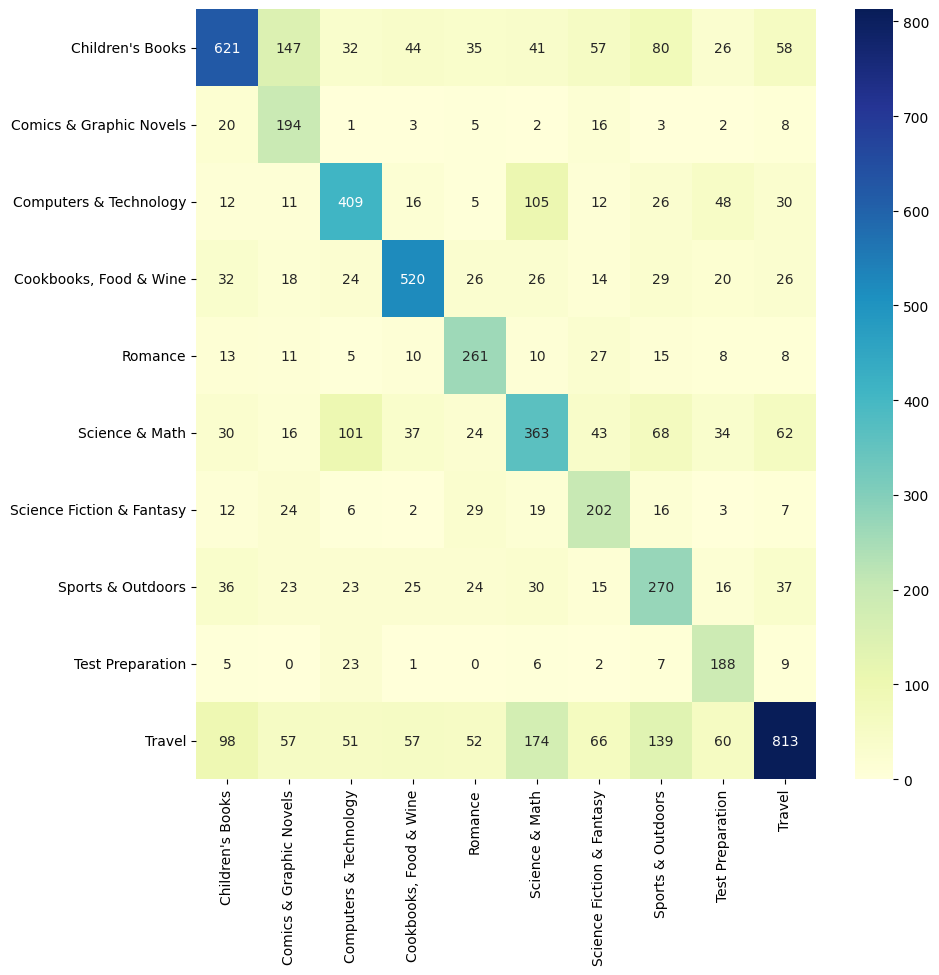

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(data=cm_test, annot=True, xticklabels=classes, yticklabels=classes, fmt='.0f', cmap='YlGnBu')

In [46]:
for i in range(len(img_names)):
    # img_list[i].append(preds[i])
    try:
        img_names[i].append(np.argmax(preds[i]))
    except:
        print(i)
        print(len(img_names))
        print(len(preds))

In [75]:
traindf.head()

,Amazon ID (ASIN),Filename,Image URL,Title,Author,Category ID,Category
0,375857508,0375857508.jpg,http://ecx.images-amazon.com/images/I/51o-a5%2...,"Alvin Ho: Allergic to Camping, Hiking, and Oth...",Lenore Look,23,Science & Math
1,980015405,0980015405.jpg,http://ecx.images-amazon.com/images/I/51jqG9AE...,Kissed By The Devil,Dashawn Taylor,22,Romance
2,804142769,0804142769.jpg,http://ecx.images-amazon.com/images/I/51pRD4ib...,Fodor's Arizona & the Grand Canyon 2015 (Full-...,Fodor's,29,Travel
3,635010801,0635010801.jpg,http://ecx.images-amazon.com/images/I/51DbBM-Y...,What Is Islam? Who Are Muslims (It's Happening...,Carole Marsh,4,Children's Books
4,1619219204,1619219204.jpg,http://ecx.images-amazon.com/images/I/51DRMfO8...,Sole Support,Kaje Harper,22,Romance


In [76]:
img_list_df = pd.DataFrame(img_list, columns=['Filename', 'label'])

In [77]:
img_list_df.head()

,Filename,label
0,0001956604.jpg,0
1,000195850X.jpg,0
2,0001961365.jpg,0
3,0001983776.jpg,0
4,0007186932.jpg,0


In [64]:
traindf.to_csv("./data/book-full-listing-train.csv", index=False)
testdf.to_csv("./data/book-full-listing-test.csv", index=False)